# Filter by correlation and cross correlation

### Imports

In [1]:
import pandas as pd

### Load in the data

In [2]:
def drop_constant_column_v2(df):
        
        drop_col = [str(i) for i in range(len(df.columns)) if df[df.keys()[i]].nunique() == 1]
        df.drop(drop_col, axis=1, inplace=True)
        
        return drop_col

In [3]:
labeled_dataset_dir = 'Summer_Datasets/2b_median_dataset.csv'
unlabeled_dataset_dir = 'Summer_Datasets/2b_dataset.csv'

df_unlab = pd.read_csv(unlabeled_dataset_dir)
df_lab = pd.read_csv(labeled_dataset_dir)

#Relabel columns so that they are easier to work with
df_lab.columns = [str(i) for i in range(len(df_lab.columns))]
df_unlab.columns = [str(i) for i in range(len(df_unlab.columns))]

# Whe should sure that both dataset has the same valid values (no zero) for each column
# First we remove all the invalid column and remove the same column in the other
drop_col = drop_constant_column_v2(df_lab)
df_unlab.drop(drop_col, axis=1, inplace=True)

# Here we do the oposite
drop_col = drop_constant_column_v2(df_unlab)
df_lab.drop(drop_col, axis=0, inplace=True)

### Define Constants

In [4]:
MAX_PMCS_TO_SELECT = 6  # this is the limit of our architecture
NUM_TARGETS = 2   # this is the number of things we are trying to predict, assumed the last N columns of df_lab

#### These are the targets for regression and the column names from the labeled dataset

In [5]:
target_col_names = list(df_lab.columns.values)[-NUM_TARGETS:]
targets = df_lab[target_col_names]

### Find how correlated each feature is with the target(s) using spearman, pearson, and kendall

In [6]:
#Parameters are the labeled dataset (pandas dataframe) and the method of correlation (string)
#To make selection easier, the average correlation between the labels will be the measure of "goodness"

#Returns dataframe with one column labels as '0' where the row numbers correspond to the columns of the labeled dataset
#        This one column dataframe is in sorted order of average correlation with the target(s)

def get_features_correlated_with_target_sorted(df_lab, method):
        
        df = df_lab.copy()
        
        #df.drop(['0'], axis=1, inplace=True)
        #last_column_name = list(df.columns.values)[-2:]
        correlation_matriz = df.corr(method)
        
        dic_params = {}
        for col in target_col_names:
            dic_params[col] = list(abs(correlation_matriz[target_col_names]).drop(target_col_names)[col])
            dic_params[col] = pd.DataFrame({col: dic_params[col]}, index=df.columns[:-NUM_TARGETS])

        ####################################################
        #Find average correlation with each target
        avg_dic_params = {}
        for key, value in dic_params.items():
            for pmc, corr in value.iterrows():
                
                corr = list(corr)[0]

                if pmc not in list(avg_dic_params.keys()):
                    avg_dic_params[pmc] = corr
                else:
                    avg_dic_params[pmc] = avg_dic_params[pmc] + corr

        for key in list(avg_dic_params.keys()):
            avg_dic_params[key] = avg_dic_params[key]/NUM_TARGETS

        avg_dic_params = pd.DataFrame(avg_dic_params, index=['Average Correlation']).T
        avg_dic_params = avg_dic_params.sort_values('Average Correlation', ascending=False)

        ####################################################

        return avg_dic_params

In [7]:
correlations = {}

#Put the dataframes in a list to preserve the row labels
correlations['spearman'] = [get_features_correlated_with_target_sorted(df_lab, 'spearman')]
correlations['pearson'] = [get_features_correlated_with_target_sorted(df_lab, 'pearson')]
correlations['kendall'] = [get_features_correlated_with_target_sorted(df_lab, 'kendall')]

### Lets visualize the average correlations and Cross Correlation

#### Spearman

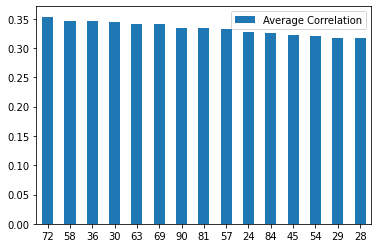

In [8]:
spear_corr = correlations['spearman'][0].head(15)
plt = spear_corr.plot.bar(rot=0)

In [9]:
spear_cross_corr = df_lab[spear_corr.T.columns].corr()
spear_cross_corr.style.background_gradient(cmap='coolwarm')

In [10]:
spear_corr = correlations['spearman'][0]
spear_cross_corr = df_lab[spear_corr.T.columns].corr()

#### Pearson

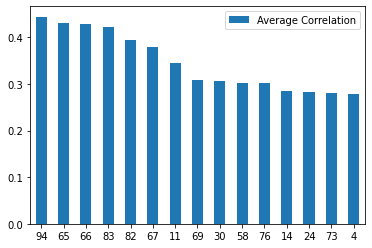

In [11]:
pear_corr = correlations['pearson'][0].head(15)
plt = pear_corr.plot.bar(rot=0)

In [12]:
pear_cross_corr = df_lab[pear_corr.T.columns].corr()
pear_cross_corr.style.background_gradient(cmap='coolwarm')

In [13]:
pear_corr = correlations['pearson'][0]
pear_cross_corr = df_lab[pear_corr.T.columns].corr()

#### Kendall

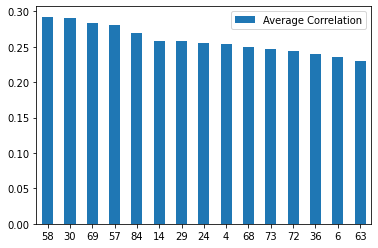

In [14]:
ken_corr = correlations['kendall'][0].head(15)
plt = ken_corr.plot.bar(rot=0)

In [15]:
ken_cross_corr = df_lab[ken_corr.T.columns].corr()
ken_cross_corr.style.background_gradient(cmap='coolwarm')

In [16]:
ken_corr = correlations['kendall'][0]
ken_cross_corr = df_lab[ken_corr.T.columns].corr()

### Select the best PMCs
#### Method: 
##### Select a set of (MAX_PMCS_TO_SELECT) that have the highest average correlation with the target(s) and lowest cross correlation with each other 

In [17]:
# Any pmc whose average correlation with the target(s) is less that this percentage of the maximum average correlation 
#   will not be included in the set of best PMCs
CORRELATION_THRESHOLD_PERCENTAGE = 0.75 

# Any pmc with an absolute correlation, with any other pmc already selected, greater than this will be 
#   considered highly correlated and will not be included in the set of best PMCs
CROSS_CORR_THRESHOLD = 0.5 

In [18]:
#This is not meant to produce a set of pmcs that will generate the best accuracy with an ML model.
#This is meant to produce a set of pmcs that can be reasonably used to model the data.

#The idea being that this function is called, then a model is trained on just those columns, and the accuracy is measured.
# then repeat to find the set of PMCs that produces the highest accuracy in those models

#cross_corr is a cross correlation matrix that is a pandas dataframe
#start_col is one of the column names in the cross correlation matrix that is a string
def select_best_pmcs(cross_corr, start_col, corr_method):
    best_set = [start_col]
    
    correlation_threshold =  CORRELATION_THRESHOLD_PERCENTAGE*max(list(correlations[corr_method][0]['Average Correlation']))
    
    for row, val in cross_corr[start_col].iteritems():
        
        if abs(val) < CROSS_CORR_THRESHOLD and row != start_col:
            best_set.append(row)
            
            #Check to see if 'row' is highly correlated with any of the other PMCs already added
            not_correlated_with_others = True
            sub_cross_corr = df_lab[best_set].corr()
            for previous_pmc, sub_val in sub_cross_corr[row].iteritems():
                
                to_add_corr = list(correlations[corr_method][0].T[previous_pmc])[0]
                
                if (abs(sub_val) > CROSS_CORR_THRESHOLD or to_add_corr < correlation_threshold) and previous_pmc != row:
                    not_correlated_with_others = False
                    break
            
            if not_correlated_with_others == False:
                best_set = best_set[:-1]
                
                
            
        if len(best_set) == MAX_PMCS_TO_SELECT:
            return best_set
        
    return best_set
    


In [19]:
def find_all_sets_of_noncorrelated_pmcs(cross_corr, corr_method):    
    method_best_pmcs = {}
    for col in cross_corr.columns:
        temp_sorted = sorted(select_best_pmcs(cross_corr, col, corr_method))
    
        sum_corr = 0
        for row, val in correlations[corr_method][0]['Average Correlation'].iteritems():
            if row in temp_sorted:
                sum_corr = sum_corr + val
        avg_avg_corr = sum_corr/len(temp_sorted)
    
        if not temp_sorted in list(method_best_pmcs.keys()) and len(temp_sorted) > 1:
            method_best_pmcs[avg_avg_corr] = temp_sorted

    method_best_pmcs = {k:method_best_pmcs[k] for k in sorted(list(method_best_pmcs.keys()), reverse=1)}
    return method_best_pmcs


In [20]:
best_spearman_pmcs = find_all_sets_of_noncorrelated_pmcs(spear_cross_corr, 'spearman')
best_spearman_pmcs

{0.31353901866375616: ['41', '58', '67', '72', '84'],
 0.3131640376710177: ['30', '41', '67', '72', '84'],
 0.31268433742629026: ['41', '67', '69', '72', '84'],
 0.31194628187631335: ['36', '41', '58', '67', '84'],
 0.31119459847847486: ['41', '58', '63', '67', '84'],
 0.31108442808734127: ['41', '57', '67', '72', '84'],
 0.309798533053329: ['24', '41', '67', '72', '84'],
 0.3097352711490453: ['41', '58', '67', '84', '90'],
 0.3095297058228807: ['41', '58', '67', '81', '84'],
 0.3078154660129246: ['29', '41', '67', '72', '84'],
 0.30743532078310165: ['41', '45', '58', '67', '84'],
 0.3072631795469555: ['14', '41', '67', '72', '84'],
 0.30715501747024365: ['41', '67', '68', '72', '84'],
 0.30711356012253843: ['41', '54', '58', '67', '84'],
 0.3068263977386983: ['30', '41', '63', '67', '80', '84'],
 0.3067654912354835: ['41', '63', '67', '69', '71', '84'],
 0.306387277895777: ['41', '63', '67', '69', '84', '89'],
 0.3062152697719154: ['28', '41', '58', '67', '84'],
 0.30578965056554386: 

In [21]:
best_pearson_pmcs = find_all_sets_of_noncorrelated_pmcs(pear_cross_corr, 'pearson')
best_pearson_pmcs

{0.3766577333516657: ['69', '94'],
 0.36999150169530864: ['65', '69'],
 0.3690472953522277: ['66', '69'],
 0.36539404644118245: ['69', '83'],
 0.3518596588705365: ['69', '82'],
 0.344451041932795: ['67', '69'],
 0.32709476541578064: ['11', '69']}

In [22]:
best_kendall_pmcs = find_all_sets_of_noncorrelated_pmcs(ken_cross_corr, 'kendall')
best_kendall_pmcs

{0.24947905973452178: ['58', '67', '72', '84'],
 0.2489181662067454: ['30', '67', '72', '84'],
 0.24843043270433107: ['36', '58', '67', '84'],
 0.2472598722985368: ['67', '69', '72', '84'],
 0.24655265872003612: ['57', '67', '72', '84'],
 0.24626001861858754: ['58', '63', '67', '84'],
 0.24513823156303471: ['58', '67', '84', '90'],
 0.24506507153767254: ['58', '67', '81', '84'],
 0.24401644450748183: ['28', '58', '67', '84'],
 0.24106565681787545: ['14', '67', '72', '84'],
 0.2409681101173926: ['29', '67', '72', '84'],
 0.24035844323937472: ['24', '67', '72', '84'],
 0.24001702978768474: ['4', '67', '72', '84'],
 0.2389196294072526: ['67', '68', '72', '84'],
 0.23816364247851046: ['67', '72', '73', '84'],
 0.23511530808842124: ['6', '67', '72', '84']}

# Now to try HCA

### Imports

In [23]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import operator

In [24]:
def create_hca(corr_method):
    '''
    Here we use dataset with all trace
    '''
    plt.figure(figsize=(45, 25))
    df_pmcs = df_unlab.copy()

    corr = 1 - df_pmcs.corr(method=corr_method).abs()
    corr_condensed = shc.distance.squareform(corr)  # convert to condensed
    # orientation="right"
    z = shc.linkage(corr_condensed, method='average')
    # if orientation right, change rotation to 0
    dendrogram = shc.dendrogram(z, labels=corr.columns, orientation="right", leaf_rotation=0, leaf_font_size=10)
    #file_name = corr_method + ".png"
    #plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
def get_features_HCA(number_of_clusters, corr_method):
    corr = 1 - df_unlab.corr(method=corr_method).abs()
    corr_condensed = shc.distance.squareform(corr)  # convert to condensed
    z = shc.linkage(corr_condensed, method='average')
    tree = shc.cut_tree(z, n_clusters=number_of_clusters)

    # create list of features for each cluster
    feat_per_cluster = [[] for i in range(0, number_of_clusters)]
    # create list of correlation values with target
    feat_correlation = [[] for i in range(0, number_of_clusters)]

    # Here we wave each features in your cluster, but we need to know wich inside of cluster has more correlation with target
    for i in range(len(df_unlab.columns)):
        cluster_id = tree[i][0]  # get cluster identification
        # add the name of this pmcs in this cluster
        feat_per_cluster[cluster_id].append(df_unlab.columns[i])

    # Now we need to get the correlation
    dictionary = correlations[corr_method][0]#get_features_correlated_with_target_sorted(df_lab, corr_method)

    for i in range(number_of_clusters):
        for j in range(len(feat_per_cluster[i])):
            # How do I assign a cluster
            feat_correlation[i].append(dictionary[dictionary.keys()[0]].get(feat_per_cluster[i][j]))

    # This part correct this problem: TypeError: '>' not supported between instances of 'float' and 'NoneType'
    for i in range(number_of_clusters):
        for j in range(len(feat_per_cluster[i])-1):
            if feat_correlation[i][j] == None:
                feat_correlation[i].pop(j)
                feat_per_cluster[i].pop(j)

    #features_correlation_per_cluster = [[] for i in range(0, number_of_clusters)]
    selected_pmcs = []
    for i in range(number_of_clusters):
        result = dict(zip(feat_per_cluster[i], feat_correlation[i]))
        dic_params = sorted(result.items(), key=operator.itemgetter(1), reverse=True)
        selected_pmcs.append(dic_params[0][0])

        #features_correlation_per_cluster[i].append(sorted(result.items(), key=operator.itemgetter(1),reverse=True))
    return selected_pmcs

In [26]:
#create_hca('spearman')

In [27]:
#create_hca('pearson')

In [28]:
#create_hca('kendall')

In [29]:
best_hca_spearman = sorted(get_features_HCA(MAX_PMCS_TO_SELECT, 'spearman'))
best_hca_pearson = sorted(get_features_HCA(MAX_PMCS_TO_SELECT, 'pearson'))
best_hca_kendall = sorted(get_features_HCA(MAX_PMCS_TO_SELECT, 'kendall'))

### Calculate the average of average correlations with the target(s)

In [30]:
best_hca_avg_corr = {}
for method in ['spearman', 'pearson', 'kendall']:
    best_hca_pmcs = sorted(get_features_HCA(MAX_PMCS_TO_SELECT, method))
    sum_corr = 0
    for row, val in correlations[method][0]['Average Correlation'].iteritems():
        if row in best_hca_pmcs:
            sum_corr = sum_corr + val
    avg_avg_corr = sum_corr/len(best_hca_pmcs)
    best_hca_avg_corr[avg_avg_corr] = (method, best_hca_pmcs)
best_hca_avg_corr

{0.18983503170321922: ('spearman', ['60', '64', '72', '84', '86', '92']),
 0.19905990324004896: ('pearson', ['69', '85', '87', '89', '92', '94']),
 0.14786549044854141: ('kendall', ['42', '58', '60', '64', '84', '92'])}

### Look at how the PMCs are correlated with each other

#### Spearman

In [31]:
hca_spear_cross_corr = df_lab[best_hca_spearman].corr()
hca_spear_cross_corr.style.background_gradient(cmap='coolwarm')

#### Pearson

In [32]:
hca_pear_cross_corr = df_lab[best_hca_pearson].corr()
hca_pear_cross_corr.style.background_gradient(cmap='coolwarm')

#### Kendall

In [33]:
hca_ken_cross_corr = df_lab[best_hca_kendall].corr()
hca_ken_cross_corr.style.background_gradient(cmap='coolwarm')

# All candidate sets of PMCs

In [34]:
candidates = {}

for i in range(len(list(best_spearman_pmcs.keys()))):
    key = 'spearman-filter-'+str(i)
    candidates[key] = best_spearman_pmcs[list(best_spearman_pmcs.keys())[i]]
    
for i in range(len(list(best_pearson_pmcs.keys()))):
    key = 'pearson-filter-'+str(i)
    candidates[key] = best_pearson_pmcs[list(best_pearson_pmcs.keys())[i]]
    
for i in range(len(list(best_kendall_pmcs.keys()))):
    key = 'kendall-filter-'+str(i)
    candidates[key] = best_kendall_pmcs[list(best_kendall_pmcs.keys())[i]]
    
candidates['spearman-hca'] = best_hca_spearman
candidates['pearson-hca'] = best_hca_pearson
candidates['kendall-hca'] = best_hca_kendall

candidates

{'spearman-filter-0': ['41', '58', '67', '72', '84'],
 'spearman-filter-1': ['30', '41', '67', '72', '84'],
 'spearman-filter-2': ['41', '67', '69', '72', '84'],
 'spearman-filter-3': ['36', '41', '58', '67', '84'],
 'spearman-filter-4': ['41', '58', '63', '67', '84'],
 'spearman-filter-5': ['41', '57', '67', '72', '84'],
 'spearman-filter-6': ['24', '41', '67', '72', '84'],
 'spearman-filter-7': ['41', '58', '67', '84', '90'],
 'spearman-filter-8': ['41', '58', '67', '81', '84'],
 'spearman-filter-9': ['29', '41', '67', '72', '84'],
 'spearman-filter-10': ['41', '45', '58', '67', '84'],
 'spearman-filter-11': ['14', '41', '67', '72', '84'],
 'spearman-filter-12': ['41', '67', '68', '72', '84'],
 'spearman-filter-13': ['41', '54', '58', '67', '84'],
 'spearman-filter-14': ['30', '41', '63', '67', '80', '84'],
 'spearman-filter-15': ['41', '63', '67', '69', '71', '84'],
 'spearman-filter-16': ['41', '63', '67', '69', '84', '89'],
 'spearman-filter-17': ['28', '41', '58', '67', '84'],
 '